# Определение токсичных комментариев

## Описание проекта

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Имеется набор данных с разметкой о токсичности комментариев.

### Цель проекта

Построить модель классификации комментариев на позитивные (нормальные) и негативные (токсичные).

Значение метрики качества *F1* должно быть не меньше 0.75. 

### Задачи проекта

1. Загрузить и подготовить данные.

2. Обучить разные модели классификации на данных.

3. Проанализировать результаты и сделать выводы.

### Описание данных

Данные находятся в файле [`toxic_comments.csv`](https://<LINK_REMOVED>/datasets/toxic_comments.csv). 

- столбец `text` содержит текст комментария;
- столбец `toxic` — целевой признак.

### Установка и обновление библиотек

In [1]:
# обновляем версии библиотек и устанавливаем дополнительные библиотеки
%pip install matplotlib==3.7.3 seaborn==0.13.1 scikit-learn==1.4.0 \
    lightgbm==4.6.0 langid==1.1.6 spacy==3.4.4 pydantic -q

Note: you may need to restart the kernel to use updated packages.


### Импорты

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

# для обработки текстов
import regex
from langid.langid import (
    LanguageIdentifier, 
    model as langid_model
)
import spacy

from sklearn.base import clone
from sklearn.feature_extraction.text import (
    strip_accents_unicode,
    TfidfVectorizer
) 
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, 
    confusion_matrix
)

# классы моделей
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from lightgbm import LGBMClassifier

### Настройки

In [3]:
# фиксируем случайное состояние
RANDOM_STATE = 42

# использовать ли готовые результаты вычислений
USE_PRECOMPUTED_LANG_GUESS = True
USE_PRECOMPUTED_LEMMATIZATION = True
USE_PRECOMPUTED_HYPERPARAMETERS = True

In [4]:
# отображать таблицы pandas полностью
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
# инициализируем индикатор прогресса в pandas
tqdm.pandas()

### Пользовательские функции

In [6]:
def plot_class_balance(target: pd.Series):
    """
    Строит диаграмму распределения классов по целевому признаку.
    """
    # строим график
    ax = sns.countplot(x=target, hue=target, stat='percent', legend=False)

    # добавляем аннотации
    for c in ax.containers:
        ax.bar_label(c, label_type='center', fmt='{:.2f} %')
    
    # оформляем график
    ax.set_ylabel('Доля (%)')
    ax.set_title('Распределение классов по целевому признаку')

    return ax

In [7]:
def plot_confusion_matrix(y_true, y_pred, normalize=None):
    """
    Строит матрицу ошибок модели классификации.
    """
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    fmt = 'd' if normalize is None else '.2%'

    plt.figure(figsize=(3, 3))
    ax = sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues_r', cbar=False)

    ax.set_xlabel('Предсказанное значение')
    ax.set_ylabel('Истинное значение')
    ax.set_title('Матрица ошибок модели')

    return ax

In [8]:
def plot_feature_importance(importance, feature_names):
    """
    Строит график важности признаков.
    """
    # формируем таблицу
    feature_df = (
        pd.DataFrame({'признак': feature_names, 'значение': importance})
        .sort_values(by='значение', key=lambda x: abs(x), ascending=False)
        .reset_index(drop=True)
    )
    # визуализируем данные в таблице
    ax = sns.barplot(data=feature_df, x='значение', y='признак')

    return ax

## Обзор данных

### Загрузка данных

In [9]:
# имя файла с данными
file_name = 'toxic_comments.csv'

# путь к файлам по умолчанию
path_default = '/datasets/'
# путь к файлам на локальном компьютере
path_local_rel = '~/datasets/'
path_local = os.path.expanduser(path_local_rel)
# путь к файлам на внешнем сервере
path_remote = 'https://<LINK_REMOVED>/datasets/'

# определение расположения файлов
if os.path.exists(path_default):
    path = path_default
    source = 'по умолчанию'
elif os.path.exists(path_local):
    path = path_local_rel
    source = 'локальный путь'
else:
    path = path_remote
    source = 'сетевой путь'
full_path = os.path.join(path, file_name)
# загрузка данных из CSV файла
data = pd.read_csv(full_path)

print(f'Данные успешно загружены из файла: {full_path} ({source})')

Данные успешно загружены из файла: ~/datasets/toxic_comments.csv (локальный путь)


### Знакомство с данными

In [10]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [11]:
print('Уникальные значения целевого признака:',
      data['toxic'].unique().tolist())

Уникальные значения целевого признака: [0, 1]


Датасет содержит тексты 159292 комментариев, размеченные по целевому признаку `toxic` — является ли комментарий токсичным (1) или нет (0).

Предсказание целевого признака, принимающего значения 0 и 1 — это задача бинарной классификации.

In [12]:
# первые 10 строк таблицы
data.head(10)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,9,alignment on this subject and which are contrary to those of DuLithgow,0


### Выводы

1. Датасет содержит тексты более 159 тысяч комментариев, размеченные по целевому признаку `toxic` — является ли комментарий токсичным (1) или нет (0). 

2. Предсказание целевого признака, принимающего значения 0 и 1 — это задача **бинарной классификации**.

## Подготовка данных

### Удаление лишнего столбца

В исходном датасете имеется лишний безымянный столбец. Видимо, это значения индекса. Они не несут полезной информации, поэтому этот столбец можно удалить.

In [13]:
# удаляем лишний столбец
data = data.drop(columns=data.columns[0])

### Очистка текстов

Проведём предварительную очистку текстов.

Приведём тексты к нижнему регистру и очистим их от URL, email и небуквенных символов. Для этого используем функцию `clean_text()`.

In [14]:
def clean_text(text):
    """
    Приводит текст к нижнему регистру и
    очищает от URL, email, небуквенных символов.
    """
    # приводим к нижнему регистру
    clean = text.lower()

    # удаляем  URL и email
    clean = regex.sub(r'(f|ht)tps?://\S+|www\.\S+|\S+@\S+\.\S+', '', clean)

    # удаляем теги HTML
    clean = regex.sub(r'<[^>]*>', ' ', clean)

    # заменяем небуквенные символы на пробелы
    clean = regex.sub(r'[^\p{Letter}]', ' ', clean)

    # удаляем лишние пробелы
    clean = ' '.join(clean.split())

    # возвращаем None, если получилась пустая строка
    return clean or None

In [15]:
# очищаем тексты
data['clean_text'] = data['text'].progress_apply(clean_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

После очистки текстов могли появиться пропущенные значения (пустые комментарии).

In [16]:
print('Количество пустых комментариев после очистки текста: '
      f"{data['clean_text'].isna().sum()}")

Количество пустых комментариев после очистки текста: 31


Удалим записи с пропущенными значениями из данных.

In [17]:
# удаляем записи с пустыми текстами
data = data.dropna().reset_index(drop=True)

### Определение языка текстов

Как показало знакомство с данными, первые 10 комментариев написаны на английском языке. Но исследовать вручную все 159 тысяч текстов невозможно, поэтому нужно использовать средства автоматического определения языка текста.

Для определения языка комментариев используем библиотеку `langid`. Функция `classify()` позволяет определить вероятный язык текста и вероятность принадлежности текста к этому языку.

Если вероятность не превышает 0.5, то будем считать определение неуверенным и вместо кода языка установим значение `not sure` ("не уверен").

Если окажется, что в корпусе присутствуют тексты на разных языках, то их нужно будет обрабатывать раздельно. И модели лучше строить отдельные для каждого языка.

Процедура определения языка текстов в большом корпусе — вычислительно затратная, поэтому для ускорения повторных запусков кода сохраним результаты в файл. 

In [18]:
# инициализируем определитель языка
language_identifier = LanguageIdentifier.from_modelstring(langid_model, norm_probs=True)

In [19]:
def guess_language(text):
    """
    Определяет язык текста. 
    Возвращает двухбуквенный код языка или 'not sure',
    если вероятность принадлежности текста к этому языку не превышает 0.5.
    """
    lang_result = language_identifier.classify(text)

    return 'not sure' if lang_result[1] <= 0.5 else lang_result[0]

In [20]:
# файл с результатами определения языка
backup_file = 'lang.csv'

# использовать ли готовые результаты в случае их наличия
if USE_PRECOMPUTED_LANG_GUESS and os.path.isfile(backup_file):
    # загружаем данные из файла
    data['lang'] = pd.read_csv(backup_file)
else:
    # определяем язык текстов
    data['lang'] = data['clean_text'].progress_apply(guess_language)
    # сохраняем результаты в файл
    data['lang'].to_csv(backup_file, index=False)

Посмотрим на результаты определения языка текстов. Выведем топ-10 языков.

In [21]:
# выводим топ-10 языков
(data['lang']
 .value_counts(normalize=True)
 .head(10)
 .to_frame()
 .style.format('{:.2%}')
)

,lang
en,97.37%
not sure,0.95%
it,0.17%
fr,0.12%
nl,0.12%
id,0.10%
de,0.10%
es,0.10%
la,0.10%
cy,0.08%


Более 97% текстов на английском языке. Для чуть менее 1% текстов уверенно определить язык не удалось. 

Остальные языки имеют незначительные доли. Проверим, не ошибки дли это. Для примера посмотрим тексты, язык которых был определён как `it` — итальянский.

In [22]:
# выводим первые 10 текстов, язык которых был определён как итальянский
data.loc[data['lang'] == 'it', ['clean_text']].head(10)

,clean_text
2091,no it doesn t
2772,no fuckin make me fudge packer gwernol more like queerhole
3165,la vierge au voile by raffaello sanzio from c rmf retouched
4026,redirect talk sun hwa filipino school
4246,faggot faggot faggot faggot
4323,redirect user talk dengero archive
4711,firearms computer game deletion question i responded talk
4875,hello i am hannahbutterface
6660,more like gayfagonaplane
7159,ditto anna lincoln


Очевидно, что все эти тексты на английском языке. 

Будем считать, что все тексты в корпусе на английском языке, а определённая классификатором принадлежность текстов к другим языкам — ошибка. Поэтому далее используем методы подготовки текстов, рассчитанные на английский язык.

Очистим тексты от нелатинских символов, которые могут встречаться в текстах. Также удалим диакритические знаки. Для этого используем функцию `remove_nonlatin()`.

In [23]:
def remove_nonlatin(text):
    """
    Очищает текст от нелатинских символов.
    """
    # заменяем нелатинские символы на пробелы
    clean = regex.sub(r'[^\p{Latin}]', ' ', text)
    # удаляем диакритические знаки
    clean = strip_accents_unicode(clean)
    # удаляем лишние пробелы
    clean = ' '.join(clean.split())

    # возвращает None, если получилась пустая строка
    return clean or None

In [24]:
# очищаем тексты
data['clean_text'] = data['clean_text'].progress_apply(remove_nonlatin)

  0%|          | 0/159261 [00:00<?, ?it/s]

### Лемматизация текстов

Лемматизируем слова в текстах. Для этого используем средства библиотеки `SpaCy`, которая позволяет автоматически лемматизировать все части речи (существительные, прилагательные, глаголы, наречия и т.д.). При лемматизации формы личного местоимения первого лица приводятся к форме `I` (заглавная буква), поэтому нужно привести все леммы к нижнему регистру.

Лемматизация большого корпуса текстов — тоже вычислительно затратная процедура. Поэтому также как и при определении языка текстов, сохраним результаты в файл для ускорения повторных запусков кода.

In [25]:
for attempt in range(2):
    try:
        # инициализируем обработчик текстов, используя словарь для английского языка
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        break
    except OSError:
        print('Словарь не найден, загружаем...')
        # загружаем словарь для английского языка
        spacy.cli.download('en_core_web_sm', False, False, '-q')
        continue
else:
    print('Ошибка при загрузке словаря.')

In [26]:
def lemmatize(text):
    """
    Лемматизирует текст.
    """
    # обрабатываем текст с помощью SpaCy
    doc = nlp(text)
    
    # получаем список лемм,
    # приводим леммы к нижнему регистру
    lemm_list = [token.lemma_.lower() for token in doc]
    
    # объединяем леммы в строку через пробел
    lemm_text = ' '.join(lemm_list)

    return lemm_text

Перед применением функции для лемматизации текстов к датасету, протестируем её на простых примерах.

In [27]:
# примеры текстов
sentence1 = "The striped bats are hanging on their feet for best" 
sentence2 = "you should be ashamed of yourself went worked" 

# помещаем тексты в датафрейм
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text']) 

# лемматизируем тексты
df_my['lemm_text'] = df_my['text'].apply(lemmatize)
df_my

,text,lemm_text
0,The striped bats are hanging on their feet for best,the stripe bat be hang on their foot for good
1,you should be ashamed of yourself went worked,you should be ashamed of yourself go work


Результаты лемматизации соответствуют ожидаемым: 
        
        striped  ------> stripe, went -------> go  

Теперь можно применить лемматизацию ко всему корпусу текстов в датасете.

In [28]:
# файл с лемматизированными текстами
backup_file = 'lemm_text.csv'

# использовать ли готовые результаты в случае их наличия
if USE_PRECOMPUTED_LEMMATIZATION and os.path.isfile(backup_file):
    # загружаем данные из файла
    data['lemm_text'] = pd.read_csv(backup_file)
else:
    # лемматизируем тексты
    data['lemm_text'] = data['clean_text'].progress_apply(lemmatize)
    # сохраняем результаты в файл
    data['lemm_text'].to_csv(backup_file, index=False)

### Удаление стоп-слов

Очистим тесты от стоп-слов, не несущих смысловой нагрузки. Для этого используем средства библиотеки `SpaCy`. Дополнительно удалим из текстов слова короче 3-х букв, которые тоже в большинстве не информативны — это предлоги, служебные слова, сокращения и т.п.

In [29]:
# создаём список стоп-слов для английского языка
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [30]:
def remove_stopwords(text, stopwords=None):
    """
    Удаляет из текста стоп-слова из списка 'stopwords'
    и слова короче 3-х букв.
    """
    if stopwords is None:
        stopwords = []
    
    clean = ' '.join([word for word in text.split() if word not in stopwords and len(word) > 2])
    
    # возвращает None, если получилась пустая строка
    return clean or None

In [31]:
# удаляем стоп-слова из текста
data['final_text'] = data['lemm_text'].progress_apply(remove_stopwords, stopwords=stop_words)

  0%|          | 0/159261 [00:00<?, ?it/s]

После очистки текстов тоже могли появиться пропущенные значения (пустые комментарии).

In [32]:
print('Количество пустых комментариев после очистки текста: '
      f"{data['final_text'].isna().sum()}")

Количество пустых комментариев после очистки текста: 210


Удалим записи с пропущенными значениями из данных.

In [33]:
# удаляем записи с пустыми текстами
data = data.dropna().reset_index(drop=True)

Проверим результаты обработки данных.

In [34]:
# общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159051 entries, 0 to 159050
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        159051 non-null  object
 1   toxic       159051 non-null  int64 
 2   clean_text  159051 non-null  object
 3   lang        159051 non-null  object
 4   lemm_text   159051 non-null  object
 5   final_text  159051 non-null  object
dtypes: int64(1), object(5)
memory usage: 7.3+ MB


In [35]:
# выводим 5 случайных записей
data.sample(n=5, random_state=RANDOM_STATE)

text  \
27882                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Пропущенные значения отсутствуют, результаты обработки текстов соответствуют ожидаемым.

Сохраним обработанные тексты с целевым признаком в файл, чтобы при необходимости можно было их использовать для обучения моделей классификации, не повторяя заново все этапы обработки текстов.

In [36]:
# сохраняем данные в файл
data[['final_text', 'toxic']].to_csv('toxic_comments_prepared.csv', index=False)

### Исследование баланса классов

Исследуем баланс классов в данных. Для этого построим диаграмму распределения классов по значению целевого признака с помощью пользовательской функции `plot_class_balance()`.

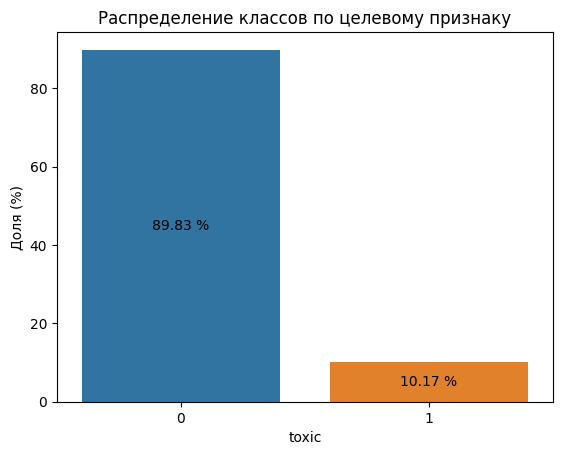

In [37]:
# строим диаграмму распределения
plot_class_balance(data['toxic']);

В данных имеется значительный дисбаланс классов: доля токсичных комментариев составляет всего ≈10%. Этот факт нужно будет учесть при подготовке выборок и построении ML моделей.

### Разделение выборок

Разделим данные на обучающую и тестовую выборки в пропорции 3:1 стратифицированным образом по целевому признаку, чтобы соотношение классов в выборках было таким же, как во всём датасете в целом.

In [38]:
# разделяем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    data['final_text'],
    data['toxic'],
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=data['toxic']
)

print('Размер обучающей выборки:', len(X_train))
print('Размер тестовой выборки:', len(X_test))

Размер обучающей выборки: 119288
Размер тестовой выборки: 39763


Проверим стратифицированность выборок по целевому признаку.

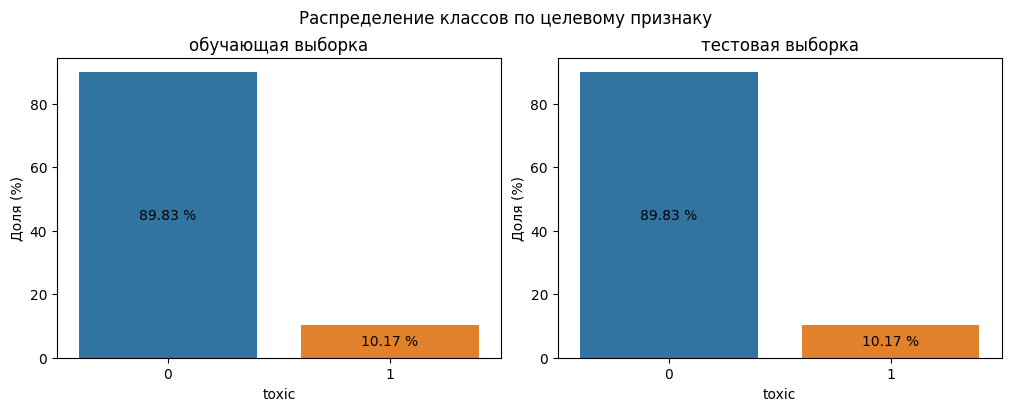

In [39]:
# создаём область построения графиков
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

# строим диаграммы распределения для выборок
ax = axes[0]
plt.sca(ax)
plot_class_balance(y_train)
title = ax.get_title()
ax.set_title('обучающая выборка')

ax = axes[1]
plt.sca(ax)
plot_class_balance(y_test)
ax.set_title('тестовая выборка')

# заголовок графиков
fig.suptitle(title);

Выборки — стратифицированные.

### Создание пайплайна

Для обучения и проверки качества моделей классификации создадим пайплайн. Использование пайплайна необходимо, чтобы избежать утечки целевого признака при кросс-валидации на этапе предварительной оценки качества моделей на обучающей выборке и подбора оптимальных значений гиперпараметров.

- Векторизация текстов осуществляется путём расчёта значений TF-IDF каждого отдельного слова в корпусе с помощью `TfidfVectorizer`.

- В качестве классификатора в шаблонном пайплайне используем дамми-модель классификации `DummyClassifier`, которая предсказывает класс случайным образом, используя информацию о распределении классов в обучающей выборке.

In [ ]:
# TF-IDF векторизатор
tfidf_vect = TfidfVectorizer()

# дамми-модель классификации 
dummy_model = DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_STATE
)

# создаём пайплайн модели
dummy_pipe = Pipeline([
    ('vectorizer', tfidf_vect),
    ('estimator', dummy_model)
])

print('Шаблон пайплайна для моделей:')
dummy_pipe

Шаблон пайплайна для моделей:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 DummyClassifier(random_state=42, strategy='stratified'))])

Посмотрим, сколько признаков (уникальных слов) получается для полной обучающей выборки.

In [41]:
# обучаем векторизатор и выводим количество признаков
print('Количество признаков:',
      clone(tfidf_vect).fit_transform(X_train).shape[1])

Количество признаков: 122544


Действительно, количество признаков огромное.

### Выводы

Исходные данные с текстами комментариев и разметкой об их токсичности обработаны и подготовлены к использованию для обучения и оценки качества моделей.

1. Выполнена **предварительная обработка** данных:
    - Удалён столбец со значениями номеров комментариев (старый индекс).
    - Тексты приведены к нижнему регистру и очищены от URL, email, HTML-тегов и небуквенных символов.

2. Установлено, что все тексты в корпусе на **английском языке**.

3. Проведена **дополнительная обработка** текстов, учитывающая язык текстов — английский.
    - Тексты очищены от нелатинских символов, удалены диакритические знаки.
    - Слова в текстах лемматизированы.
    - Из текстов удалены стоп-слова.
    - Из корпуса удалены пустые тексты, появившиеся в результате обработки.
    
4. Обнаружен **дисбаланс классов** по значению целевого признака: доля токсичных комментариев составляет всего ≈10%. Этот факт нужно учитывать при подготовке выборок и построении ML моделей.

5. Данные разделены на обучающую и тестовую выборки в пропорции 3:1 стратифицированным образом по целевому признаку, чтобы соотношение классов в выборках было таким же, как во всём датасете в целом.

6. Подготовлен шаблон **пайплайна** для обучения и проверки качества моделей классификации. Использование пайплайна необходимо, чтобы избежать утечки целевого признака при кросс-валидации на этапе предварительной оценки качества моделей на обучающей выборке и подбора оптимальных значений гиперпараметров.

    - Векторизация текстов осуществляется путём расчёта значений TF-IDF каждого отдельного слова в корпусе с помощью `TfidfVectorizer`.

    - В качестве классификатора в шаблонном пайплайне используется дамми-модель классификации `DummyClassifier`, которая предсказывает класс случайным образом, используя данные о распределении классов в обучающей выборке.

## Обучение моделей

### Logistic Regression

Логистическая регрессия — базовая модель бинарной классификации.

Для учёта дисбаланса классов зададим параметр `class_weight='balanced'`.

Чтобы попробовать разные варианты регуляризации (L1 или L2), нужно использовать `solver='liblinear'`, при этом поскольку датасет большой, то надо увеличить максимальное число итераций алгоритма `max_iter` (значение по умолчанию — 100).

In [42]:
# модель
model = LogisticRegression(
    class_weight='balanced',
    solver='liblinear',
    max_iter=1000,
    random_state=RANDOM_STATE
)

# создаём пайплайн модели
logreg_pipe = clone(dummy_pipe).set_params(
    estimator = model
)

print('Пайплайн модели:')
logreg_pipe

Пайплайн модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

Оценим качество модели, рассчитав метрику F1 при кросс-валидации по 5 блокам на обучающей выборке.

In [43]:
%%time
# метрика F1 при кросс-валидации на обучающей выборке
cv_score = cross_val_score(
    logreg_pipe, 
    X_train, 
    y_train, 
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
).mean()
print(f'Метрика F1 модели при кросс-валидации на обучающей выборке: {cv_score:.4f}')
print()

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.7536

CPU times: user 860 ms, sys: 667 ms, total: 1.53 s
Wall time: 28.1 s


Попробуем подобрать значения гиперпараметров модели, которые помогут повысить её качество, т.е. получить большее значение метрики F1 при кросс-валидации на обучающей выборке. Для модели логистической регрессии подберём следующие параметры: `penalty` — тип регуляризации (L1 или L2) и `C` — силу регуляризации.

Для определения оптимальных значений гиперпараметров используем поиск по сетке с помощью `GridSearchCV`.

Также измерим время обучения модели на обучающей выборке.

Чтобы не повторять заново поиск оптимальных значений гиперпараметров при каждом перезапуске кода, найденные оптимальные значения зафиксированы в коде. Выбор режима (выполнять поиск заново или нет) осуществляется с помощью задания константы `USE_PRECOMPUTED_HYPERPARAMETERS` в разделе "Настройки".

В результате получим: 
- обученный пайплайн модели с оптимальными гиперпараметрами,
- среднее значение метрики F1 модели при кросс-валидации на обучающей выборке,
- время обучения модели на обучающей выборке.

In [44]:
%%time
if  USE_PRECOMPUTED_HYPERPARAMETERS:
    # параметры лучшей модели
    logreg_pipe_best_params = {
        'estimator__penalty': 'l2',
        'estimator__C': 6, 
    }

    # лучшая модель
    logreg_pipe = logreg_pipe.set_params(**logreg_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_logreg_pipe = cross_val_score(
        logreg_pipe, 
        X_train, 
        y_train, 
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=0
    ).mean()

else:
    # словарь со списками параметров для перебора
    parameters = {
        'estimator__penalty': ['l1', 'l2'],
        'estimator__C': range(1, 11),
    }
    # инициализируем класс для автоматизированного подбора параметров
    grid_search = GridSearchCV(
        logreg_pipe,
        parameters,
        cv=5,
        scoring='f1',
        refit=False,
        n_jobs=-1,
        verbose=0
    )
    # запускаем подбор параметров 
    grid_search.fit(X_train, y_train)

    # параметры лучшей модели
    logreg_pipe_best_params = grid_search.best_params_
    
    # лучшая модель
    logreg_pipe = logreg_pipe.set_params(**logreg_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_logreg_pipe = grid_search.best_score_

# обучаем модель и измеряем время обучения 
fit_time_logreg_pipe = %timeit -t -o -n 1 -r 1 -q \
    logreg_pipe.fit(X_train, y_train)
fit_time_logreg_pipe = fit_time_logreg_pipe.average

print('Пайплайн модели:')
display(logreg_pipe)

print('Метрика F1 модели при кросс-валидации на обучающей выборке: '
      f'{cv_score_logreg_pipe:.4f}')

print('Время обучения модели: '
      f'{fit_time_logreg_pipe:.2f} s')
print()

Пайплайн модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 LogisticRegression(C=6, class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.7646
Время обучения модели: 13.59 s

CPU times: user 18.5 s, sys: 14.8 s, total: 33.3 s
Wall time: 44.3 s


### SVM

Попробуем использовать для классификации комментариев метод опорных векторов (SVM). Поскольку данных и признаков много, то используем более быструю реализацию этого метода с помощью градиентного спуска в классе `SGDClassifier` с указанием функции потерь `loss='hinge'`. Для учёта дисбаланса классов также зададим параметр `class_weight='balanced'`.

In [45]:
# модель
model = SGDClassifier(
    loss='hinge',
    class_weight='balanced',
    random_state=RANDOM_STATE,
)

# создаём пайплайн модели
svm_pipe = clone(dummy_pipe).set_params(
    estimator = model
)

print('Пайплайн модели:')
svm_pipe

Пайплайн модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 SGDClassifier(class_weight='balanced', random_state=42))])

Оценим качество модели, рассчитав метрику F1 при кросс-валидации по 5 блокам на обучающей выборке.

In [46]:
%%time
# метрика F1 при кросс-валидации на обучающей выборке
cv_score = cross_val_score(
    svm_pipe, 
    X_train, 
    y_train, 
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=0
).mean()
print(f'Метрика F1 модели при кросс-валидации на обучающей выборке: {cv_score:.4f}')
print()

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.7455

CPU times: user 771 ms, sys: 273 ms, total: 1.04 s
Wall time: 19 s


Попробуем подобрать значения гиперпараметров модели, которые помогут повысить её качество, т.е. получить большее значение метрики F1 при кросс-валидации на обучающей выборке. Подберём параметр `alpha`, который регулирует силу регуляризации и скорость обучения.

Для определения оптимальных значений гиперпараметров используем поиск по сетке с помощью `GridSearchCV`.

Также измерим время обучения модели на обучающей выборке.

Чтобы не повторять заново поиск оптимальных значений гиперпараметров при каждом перезапуске кода, найденные оптимальные значения зафиксированы в коде. Выбор режима (выполнять поиск заново или нет) осуществляется с помощью задания константы `USE_PRECOMPUTED_HYPERPARAMETERS` в разделе "Настройки".

В результате получим: 
- обученный пайплайн модели с оптимальными гиперпараметрами,
- среднее значение метрики F1 модели при кросс-валидации на обучающей выборке,
- время обучения модели на обучающей выборке.

In [47]:
%%time
if  USE_PRECOMPUTED_HYPERPARAMETERS:
    # параметры лучшей модели
    svm_pipe_best_params = {
        'estimator__penalty': 'l1',
        'estimator__alpha': 1e-6,
    }

    # лучшая модель
    svm_pipe = svm_pipe.set_params(**svm_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_svm_pipe = cross_val_score(
        svm_pipe, 
        X_train, 
        y_train, 
        scoring='f1',
        cv=5,
        n_jobs=-1,
        verbose=0
    ).mean()

else:
    # словарь со списками параметров для перебора
    parameters = {
        'estimator__penalty': ['l1', 'l2'],
        'estimator__alpha': [10**(-n) for n in range(3, 8)],
    }
    # инициализируем класс для автоматизированного подбора параметров
    grid_search = GridSearchCV(
        svm_pipe,
        parameters,
        cv=5,
        scoring='f1',
        refit=False,
        n_jobs=-1,
        verbose=0
    )
    # запускаем подбор параметров 
    grid_search.fit(X_train, y_train)

    # параметры лучшей модели
    svm_pipe_best_params = grid_search.best_params_

    # лучшая модель
    svm_pipe = svm_pipe.set_params(**svm_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_svm_pipe = grid_search.best_score_

# обучаем модель и измеряем время обучения 
fit_time_svm_pipe = %timeit -t -o -n 1 -r 1 -q \
    svm_pipe.fit(X_train, y_train)
fit_time_svm_pipe = fit_time_svm_pipe.average

print('Пайплайн модели:')
display(svm_pipe)

print('Метрика F1 модели при кросс-валидации на обучающей выборке: '
      f'{cv_score_svm_pipe:.4f}')

print('Время обучения модели: '
      f'{fit_time_svm_pipe:.2f} s')
print()

Пайплайн модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 SGDClassifier(alpha=1e-06, class_weight='balanced',
                               penalty='l1', random_state=42))])

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.7493
Время обучения модели: 15.98 s

CPU times: user 16.9 s, sys: 701 ms, total: 17.6 s
Wall time: 45.5 s


### LightGBM

Применим для классификации комментариев продвинутую модель градиентного бустинга на деревьях решений — LightGBM. Для учёта дисбаланса классов зададим параметр `is_unbalance=True`.

In [48]:
# модель
model = LGBMClassifier(
    objective='binary',
    is_unbalance=True,
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    verbose=-1, 
)

# создаём пайплайн модели
lgbm_pipe = clone(dummy_pipe).set_params(
    estimator = model
)

print('Пайплайн модели:')
lgbm_pipe

Пайплайн модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 LGBMClassifier(is_unbalance=True, n_jobs=-1,
                                objective='binary', random_state=42,
                                verbose=-1))])

Оценим качество модели, рассчитав метрику F1 при кросс-валидации по 5 блокам на обучающей выборке.

In [49]:
%%time
# метрика F1 при кросс-валидации на обучающей выборке
cv_score = cross_val_score(
    lgbm_pipe, 
    X_train, 
    y_train, 
    scoring='f1',
    cv=5,
    verbose=0
).mean()
print(f'Метрика F1 модели при кросс-валидации на обучающей выборке: {cv_score:.4f}')
print()

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.7417

CPU times: user 12min 52s, sys: 3.9 s, total: 12min 56s
Wall time: 4min 20s


Попробуем подобрать значения гиперпараметров модели, которые помогут повысить её качество, т.е. получить большее значение метрики F1 при кросс-валидации на обучающей выборке. 

Подберём параметр  `num_leaves` — максимальное количества листьев в каждом дереве. Задание этого параметра ограничивает рост дерева и таким образом препятствует переобучению модели, но также ограничивает способность модели адаптироваться к обучающим данным. По умолчанию `num_leaves=31`, и чтобы повысить качество модели, нужно его увеличивать. Однако с ростом качества увеличивается и время обучения модели, поэтому приходится искать компромисс. 

Для определения оптимальных значений гиперпараметров используем поиск по сетке с помощью `GridSearchCV`.

Кроме того, измерим время обучения модели на обучающей выборке.

Чтобы не повторять заново поиск оптимальных значений гиперпараметров при каждом перезапуске кода, найденные оптимальные значения зафиксированы в коде. Выбор режима (выполнять поиск заново или нет) осуществляется с помощью задания константы `USE_PRECOMPUTED_HYPERPARAMETERS` в разделе "Настройки".

В результате получим: 
- обученный пайплайн модели с оптимальными гиперпараметрами,
- среднее значение метрики F1 модели при кросс-валидации на обучающей выборке,
- время обучения модели на обучающей выборке.

In [50]:
%%time
if  USE_PRECOMPUTED_HYPERPARAMETERS:
    # параметры лучшей модели
    lgbm_pipe_best_params = {
        'estimator__num_leaves': 127,
    }

    # лучшая модель
    lgbm_pipe = lgbm_pipe.set_params(**lgbm_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_lgbm_pipe = cross_val_score(
        lgbm_pipe, 
        X_train, 
        y_train, 
        scoring='f1',
        cv=5,
        verbose=0
    ).mean()

else:
    # словарь со списками параметров для перебора
    parameters = {
        'estimator__num_leaves': [2**n - 1 for n in range(5, 8)],
    }
    # инициализируем класс для автоматизированного подбора параметров
    grid_search = GridSearchCV(
        lgbm_pipe,
        parameters,
        cv=5,
        scoring='f1',
        refit=False,
        verbose=0
    )
    # запускаем подбор параметров 
    grid_search.fit(X_train, y_train)

    # параметры лучшей модели
    lgbm_pipe_best_params = grid_search.best_params_

    # лучшая модель
    lgbm_pipe = lgbm_pipe.set_params(**lgbm_pipe_best_params)

    # метрика лучшей модели при кросс-валидации на обучающей выборке
    cv_score_lgbm_pipe = grid_search.best_score_

# обучаем модель и измеряем время обучения 
fit_time_lgbm_pipe = %timeit -t -o -n 1 -r 1 -q \
    lgbm_pipe.fit(X_train, y_train)
fit_time_lgbm_pipe = fit_time_lgbm_pipe.average

print('Пайплайн модели:')
display(lgbm_pipe)

print('Метрика F1 модели при кросс-валидации на обучающей выборке: '
    f'{cv_score_lgbm_pipe:.4f}')

print('Время обучения модели: '
      f'{fit_time_lgbm_pipe:.2f} s')
print()

Пайплайн модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 LGBMClassifier(is_unbalance=True, n_jobs=-1, num_leaves=127,
                                objective='binary', random_state=42,
                                verbose=-1))])

Метрика F1 модели при кросс-валидации на обучающей выборке: 0.7556
Время обучения модели: 143.47 s

CPU times: user 37min 53s, sys: 16.4 s, total: 38min 10s
Wall time: 12min 13s


### Выбор лучшей модели

Сведём результаты обучения моделей в итоговую таблицу. В таблице будут следующие поля:
- `model_class` — класс модели,
- `pipeline` — пайплайн модели с оптимальными гиперпараметрами,
- `cv_f1` — значение метрики *F1* при кросс-валидации на обучающей выборке,
- `fit_time_s` — время обучения модели на обучающей выборке (в секундах).

In [51]:
# столбцы таблицы
columns = [
    'model_class',
    'pipeline',
    'cv_f1',
    'fit_time_s'
]

# формируем таблицу
results = pd.DataFrame(
    [
        [
            'LogisticRegression',
            str(logreg_pipe),
            cv_score_logreg_pipe,  
            fit_time_logreg_pipe,
        ],
        [
            'SGDClassifier',
            str(svm_pipe),
            cv_score_svm_pipe, 
            fit_time_svm_pipe,
        ],
        [
            'LGBMClassifier',
            str(lgbm_pipe),
            cv_score_lgbm_pipe,  
            fit_time_lgbm_pipe,
        ],
    ],
    columns=columns
).set_index('model_class')

In [52]:
# выводим таблицу
(results
 .sort_values(by='cv_f1', ascending=False)
 .style
 .format({
     'cv_f1': '{:.4f}',
     'fit_time_s': '{:.2f}',
 })
 .highlight_min('cv_f1', color='pink')
 .highlight_max('cv_f1', color='lightgreen') 
 .highlight_min('fit_time_s', color='lightgreen')
 .highlight_max('fit_time_s', color='pink') 
)

,pipeline,cv_f1,fit_time_s
model_class,,,
LogisticRegression,"Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('estimator', LogisticRegression(C=6, class_weight='balanced', max_iter=1000, random_state=42, solver='liblinear'))])",0.7646,13.59
LGBMClassifier,"Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('estimator', LGBMClassifier(is_unbalance=True, n_jobs=-1, num_leaves=127, objective='binary', random_state=42, verbose=-1))])",0.7556,143.47
SGDClassifier,"Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('estimator', SGDClassifier(alpha=1e-06, class_weight='balanced', penalty='l1', random_state=42))])",0.7493,15.98


Максимальное значение метрики *F1* при кросс-валидации на обучающей выборке и минимальное время обучения среди рассмотренных моделей показала **логистическая регрессия** `LogisticRegression` с ослабленной L2-регуляризацией (параметр `C=6`). Время обучения модели приемлемое. Кроме того, эта модель обладает наилучшей интерпретируемостью среди рассмотренных моделей.

Модель **LightGBM** `LGBMClassifier` с 127 листов в каждом дереве показала немного меньший, но тоже достойный результат, удовлетворяющий заданному требованию: значение метрики *F1* > 0.75. Однако её существенный недостаток — слишком большое время обучения.

Модель **SVM** `SGDClassifier` с L1-регуляризацией и параметром `alpha=1e-6` показала недостаточное значение метрики *F1* < 0.75.

По критерию максимального значения метрики *F1* **лучшая модель** из рассмотренных — это логистическая регрессия.

In [53]:
# лучшая модель
best_model = logreg_pipe

print('Пайплайн лучшей модели:')
best_model

Пайплайн лучшей модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 LogisticRegression(C=6, class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

### Выводы

1. Обучены и проверены на обучающей выборке путём кросс-валидации модели 3-х классов, включённые в построенный пайплайн:
    - логистическая регрессия `LogisticRegression`,
    - модель классификации методом опорных векторов (SVM) с использованием градиентного спуска `SGDClassifier`
    - модель классификации LightGBM `LGBMClassifier`.

2. При построении моделей использовано взвешивание классов для учёта их дисбаланса в данных.

3. Для каждой модели подобраны оптимальные значения гиперпараметров, максимизирующие метрику *F1* при кросс-валидации на обучающей выборке.

4. Измерено время обучения каждой модели на обучающей выборке.

5. По критерию максимального значения метрики *F1* при кросс-валидации на обучающей выборке выбрана **лучшая модель** — логистическая регрессия с ослабленной L2-регуляризацией (параметр `C=6`). Время обучения модели приемлемое. Дополнительное её преимущество — хорошая интерпретируемость.


## Тестирование лучшей модели

### Проверка качества модели

Получим предсказания лучшей модели на тестовой выборке и проверим её качество по метрике *F1*.

In [54]:
# делаем предсказания на тестовой выборке
y_pred = best_model.predict(X_test)

# метрика F1 на тестовой выборке
best_model_test_score = f1_score(y_test, y_pred)

print(f'Метрика F1 лучшей модели на тестовой выборке: {best_model_test_score:.4f}')

Метрика F1 лучшей модели на тестовой выборке: 0.7639


Значение метрики *F1* на тестовой выборке удовлетворяет заданному требованию *F1* > 0.75 и практически совпадает со значением, полученным при кросс-валидации на обучающей выборке. Значит, модель не переобучилась и качество её предсказаний стабильно.

### Проверка на адекватность

Проверим лучшую модель на адекватность, сравнив её с дамми-моделью классификации `DummyClassifier`, которая предсказывает класс случайным образом, используя информацию о распределении классов в обучающей выборке. Для этого рассчитаем метрику *F1* дамми-модели на тестовой выборке.

Модель можно считать адекватной, если качество её предсказаний на тестовой выборке существенно лучше, чем у дамми-модели. 

*Примечание:* `DummyClassifier` *с параметрами по умолчанию всегда предсказывает мажорный класс, поэтому когда старший класс — минорный, то и Precision = 0, и Recall = 0, а значит и F1 = 0. Поэтому логичнее использовать для сравнения* `DummyClassifier(strategy='stratified')`.

In [55]:
# обучаем дамми-модель на обучающей выборке
dummy_pipe.fit(X_train, y_train)

# делаем предсказания на тестовой выборке
y_pred_dummy = dummy_pipe.predict(X_test)

# метрика F1 на тестовой выборке
dummy_model_test_score = f1_score(y_test, y_pred_dummy)

print('Пайплайн дамми-модели:')
display(dummy_pipe)

print(f'Метрика F1 дамми-модели на тестовой выборке: {dummy_model_test_score:.4f}')

Пайплайн дамми-модели:


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('estimator',
                 DummyClassifier(random_state=42, strategy='stratified'))])

Метрика F1 дамми-модели на тестовой выборке: 0.0950


Дамми-модель показала намного худшее качество. Значит, выбранная лучшая модель — логистическая регрессия — адекватно классифицирует комментарии по токсичности.

### Анализ ошибок модели

Посмотрим на матрицу ошибок лучшей модели на тестовой выборке. Для этого используем пользовательскую функцию `plot_confusion_matrix()`, указав аргумент `normalize='all'` для нормировки на размер выборки.

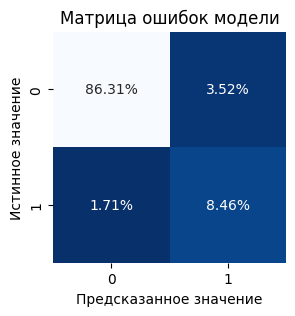

In [56]:
# строим матрицу ошибок модели
plot_confusion_matrix(y_test, y_pred, normalize='all');

По матрице ошибок сразу же видно, что *Recall* > *Precision*.

Рассчитаем метрики качества бинарной классификации:

- *Accuracy* — доля правильных предсказаний модели. 
- *Precision* — доля верно классифицированных объектов класса 1 от всех объектов, которые модель отнесла к классу 1.
- *Recall* — доля верно классифицированных объектов класса 1 от всех объектов, принадлежащих к классу 1.
- *Specificity* — доля верно классифицированных объектов класса 0. 
- *F1* — среднее гармоническое *Precision* и *Recall*.

In [57]:
# считаем метрики
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
f1 = best_model_test_score

# объединяем значения в DataFrame
scores = pd.DataFrame(
    {'значение': [accuracy, precision, recall, specificity, f1]}, 
    index=['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1']
)
scores.round(4)

,значение
Accuracy,0.9477
Precision,0.7063
Recall,0.8318
Specificity,0.9608
F1,0.7639


Анализ метрик качества классификации показывает:
- В целом модель даёт верные предсказания в ≈95% случаев (метрика *Accuracy*). Но в ситуации дисбаланса классов этот показатель неадекватно отражает качество модели. 
- Среди комментариев, которые модель классифицировала как токсичные, таковыми на самом деле оказались ≈70% (метрика *Precision*). Это означает, что в ≈30% случаев отмеченный моделью как токсичный комментарий на самом деле нормальный.
- Модель смогла верно выявить ≈83% токсичных комментариев (метрика *Recall*). Соответственно, в ≈17% случаев модель не смогла распознать токсичный комментарий.
- Модель верно классифицировала ≈96% нормальных комментариев как не токсичные. Соответственно, лишь в ≈4% случаев модель классифицирует нормальный комментарий как токсичный.
- Значения метрик *Precision* и *Recall* сбалансированны (метрика *F1*)

Таким образом, при значении порога классификации по умолчанию (0.5) модель довольно хорошо выявляет токсичные комментарии, но также нередко считает токсичными и нормальные комментарии — в этом случае требуется рассмотрение модератором. При необходимости соотношение *Precision*/*Recall* можно настроить подбором порога классификации. В редких случаях модель также может классифицировать нормальный комментарий как токсичный, тогда тоже может потребоваться вмешательство модератора.

### Оценка значимости признаков

Посмотрим, какие же признаки (слова в тексте комментария) наиболее значимы для модели при предсказании того, что комментарий является токсичным.

Важность признаков для модели логистической регрессии можно оценить по весам признаков в обученной модели.

In [58]:
# названия признаков - слова в тексте
feature_names = best_model['vectorizer'].get_feature_names_out()

# коэффициенты (веса) признаков в модели
coef = best_model['estimator'].coef_[0]

# сортируем коэффициенты и названия признаков по убыванию значения коэффициента
idx_sort_desc = coef.argsort()[::-1]
coef = coef[idx_sort_desc]
feature_names = feature_names[idx_sort_desc]

Выведем топ-20 слов, наличие которых в тексте комментария сильнее всего повышает вероятность классификации моделью такого комментария как токсичного. Используем для этого пользовательскую функцию для визуализации значимости признаков для модели `plot_feature_importance()`.

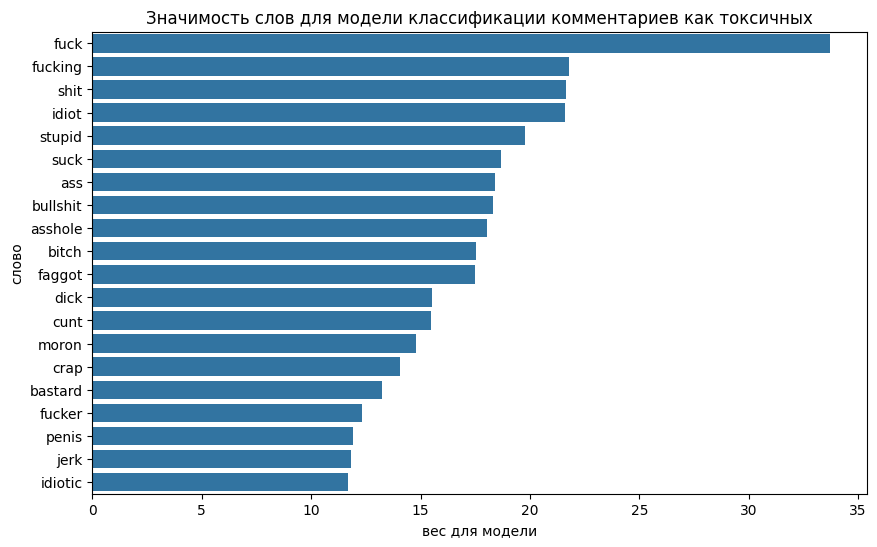

In [59]:
# количество наиболее важных признаков
top = 20

# задаём размер графика
plt.figure(figsize=(10, top//10*3))

# строим график важности признаков для модели
plot_feature_importance(coef[:top], feature_names[:top])

# оформляем график
plt.xlabel('вес для модели')
plt.ylabel('слово')
plt.title('Значимость слов для модели классификации комментариев как токсичных');

Вполне ожидаемо, что в топ-20 попала обсценная и оскорбительная лексика, причём слово "fuck" лидирует с большим отрывом, а на 2-м и 17-м местах тоже однокоренные слова.

### Выводы

1. Значение метрики *F1* лучшей модели классификации на тестовой выборке получилось более 0.76, что удовлетворяет заданному требованию *F1* > 0.75 и практически совпадает со значением, полученным при кросс-валидации на обучающей выборке. Значит, модель не переобучилась и качество её предсказаний стабильно.

2. Проверка лучшей модели на адекватность показала, что модель хорошо справляется с задачей классификации комментариев по токсичности: качество её предсказаний намного лучше, чем у дамми-модели, которая предсказывает класс случайным образом, используя данные о распределении классов в обучающей выборке.

3. Анализ ошибок модели на тестовой выборке показал, что при значении порога классификации по умолчанию (0.5) модель смогла верно выявить ≈83% токсичных комментариев, при этом среди комментариев, которые модель классифицировала как токсичные, таковыми на самом деле оказались лишь ≈70%. Таким образом, модель довольно хорошо выявляет токсичные комментарии, но также нередко считает токсичными и нормальные комментарии — в этом случае требуется рассмотрение модератором.

4. Оценка значимости признаков для модели показала, что наличие в тексте комментария обсценной и оскорбительной лексики сильно всего повышает вероятность классификации моделью такого комментария как токсичного.

## Общий вывод по проекту

1. В проекте была поставлена **задача**: используя корпус текстов комментариев с разметкой об их токсичности, построить модель классификации комментариев на позитивные (нормальные) и негативные (токсичные). 
    - Требования к модели: значение метрики качества *F1* не меньше 0.75. 
    
2. Исходный датасет содержит тексты более 159 тысяч комментариев, размеченные по целевому признаку `toxic` — является ли комментарий токсичным (1) или нет (0). Предсказание целевого признака, принимающего значения 0 и 1 — это задача **бинарной классификации**.

3. Тексты комментариев обработаны и подготовлены к использованию для обучения и оценки качества моделей.
    - Установлено, что все тексты в корпусе на **английском языке**.
    - Выполнена **обработка текстов**:
        - приведение символов к нижнему регистру,
        - очистка от URL, email, HTML-тегов, небуквенных и нелатинских символов, диакритических знаков,
        - лемматизация слов,
        - удаление стоп-слов,
        - удаление пустых текстов, появившихся в результате обработки.
  
4. Обнаружен **дисбаланс классов** по значению целевого признака: доля токсичных комментариев составляет всего ≈10%. Этот факт учтён при подготовке выборок и построении ML моделей:
    - Данные разделены на обучающую и тестовую выборки в пропорции 3:1 стратифицированным образом по целевому признаку, чтобы соотношение классов в выборках было таким же, как во всём датасете в целом.
    - При построении моделей использовано взвешивание классов.

5. Обучены и проверены на обучающей выборке путём кросс-валидации **ML модели** 3-х классов: логистическая регрессия `LogisticRegression`, модель классификации методом опорных векторов (SVM) с использованием градиентного спуска `SGDClassifier` и  модель классификации LightGBM `LGBMClassifier`.
    - Модели включены в пайплайн, содержащий векторизатор текстов путём расчёта значений TF-IDF каждого отдельного слова в корпусе `TfidfVectorizer`. Использование пайплайна необходимо, чтобы избежать утечки целевого признака при кросс-валидации.
    - Для каждой модели подобраны оптимальные значения гиперпараметров, максимизирующие метрику *F1* при кросс-валидации на обучающей выборке.
    - Измерено время обучения каждой модели на обучающей выборке.

6.  Выбрана **лучшая модель** по критерию максимального значения метрики *F1* при кросс-валидации на обучающей выборке — **логистическая регрессия** с ослабленной L2-регуляризацией (параметр `C=6`). Время обучения модели оказалось невелико. Дополнительное её преимущество — хорошая интерпретируемость.

7. Качество лучшей модели классификации проверено на тестовой выборке.
    - Значение метрики *F1* модели на тестовой выборке **превышает 0.76**, что удовлетворяет заданному требованию *F1* > 0.75 и практически совпадает со значением, полученным при кросс-валидации на обучающей выборке. Значит, модель не переобучилась и качество её предсказаний стабильно.
    - Модель хорошо справляется с задачей классификации комментариев по токсичности: качество её предсказаний намного лучше, чем у дамми-модели, которая предсказывает класс случайным образом, используя данные о распределении классов в обучающей выборке.
    - Модель смогла верно выявить ≈83% токсичных комментариев, при этом среди комментариев, которые модель классифицировала как токсичные, таковыми на самом деле оказались лишь ≈70%. 
    - Наиболее значимо для классификации моделью комментария как токсичного наличие в тексте обсценной и оскорбительной лексики.

**Итоговый вывод:**

Построенная модель классификации довольно хорошо, хотя и не идеально, выявляет токсичные комментарии, но также нередко считает токсичными и нормальные комментарии — в этом случае требуется рассмотрение модератором. При этом модель смогла правильно уловить связь между наличием в тексте комментария обсценной и оскорбительной лексики и его токсичностью.

**Рекомендации по дальнейшему повышению качества модели:**
- Попробовать настроить метод лемматизации текстов, чтобы объединить однокоренные слова, относящиеся к разным частям речи.
- Попробовать другие методы векторизации текстов, например, использовать эмбебеддинги слов, полученные с помощью языковой модели, например BERT.
- Попробовать другие модели классификации, например, нейронные сети или модели на основе градиентного бустинга с хорошо подобранными гиперпараметрами.